# Clustering

### Description

- Cluster funds using k-means

In [159]:
import feather
import numpy as np
import datetime
import pandas as pd
from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, SpectralClustering

from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

# Setup

In [373]:
# Convert to date format
begin_date = '2018-01-01' 
end_date = '2019-01-01'

## Load Data

In [374]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)

returns = returns.query('caldt >= @begin_date and caldt <= @end_date')

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

row_info = row_info.query('report_dt >= @begin_date and report_dt <= @end_date')

row_info.reset_index(inplace=True,drop=True)
row_info['row'] = row_info.index

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

holdings = holdings[row_info.row.values]

print('Shape of row_info information')
print(row_info.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of row_info information
(2020, 8)
Shape of holding information
(2020, 56820)


In [375]:
row_info.report_dt.describe()

count                    2020
unique                      1
top       2018-12-31 00:00:00
freq                     2020
first     2018-12-31 00:00:00
last      2018-12-31 00:00:00
Name: report_dt, dtype: object

## Checking the data

In [376]:
mask_columns = pd.Series(np.squeeze(np.array(holdings.sum(0))) > 10)

In [377]:
holdings = holdings[:,mask_columns.values]
col_info = col_info.loc[mask_columns.values,:]

col_info.reset_index(drop = True,inplace=True)

In [378]:
print(
    holdings.shape,
    row_info.shape,
    col_info.shape)

(2020, 3190) (2020, 8) (3190, 5)


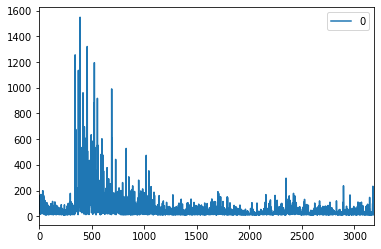

In [379]:
# Sum per stock
pd.DataFrame(holdings.sum(0)).T.plot()

In [380]:
col_info['sum'] = holdings.sum(0).T
col_info.sort_values(by = 'sum',ascending=False).head(10)

,security_name,cusip,crsp_company_key,col_old,col,sum
387,MICROSOFT CORP,59491810,3006728,591,564,1548.946399
455,GENERAL ELECTRIC CO,36960410,3004314,662,635,1321.133990
340,CITIGROUP INC,17296710,3002257,542,515,1256.047592
388,PFIZER INC,71708110,3008120,592,565,1225.247587
523,EXXON MOBIL CORP,30231G10,3003728,739,710,1195.337256
371,CISCO SYSTEMS INC,17275R10,3002250,574,547,1135.485505
688,JOHNSON & JOHNSON,47816010,3005747,926,893,990.976759
415,INTEL CORP,45814010,3005322,621,594,960.901433
552,BANK OF AMERICA CORP,06050510,3001168,771,742,917.795021
518,WAL MART STORES INC,93114210,3011176,734,705,880.850257


In [382]:
i = 100
my_sum = holdings[:,i].toarray().T.flatten()

print('Security:')
print(col_info.loc[i,:].security_name)
print()
print('Sum of holdings:             {:10.2f}'.format(np.sum(my_sum)))
print('Number of companies holding: {:10.2f}'.format(np.sum(my_sum != 0)))
print('Average position:            {:10.2f}'.format(np.sum(my_sum) / np.sum(my_sum != 0)))

Security:
NEUROCRINE BIOSCIENCES INC

Sum of holdings:                  50.27
Number of companies holding:      75.00
Average position:                  0.67


In [383]:
colsums = pd.DataFrame(holdings.sum(0)).T

In [384]:
colsums.idxmax()

0    387
dtype: int64

In [385]:
col_info.loc[462]

security_name       NVIDIA CORP
cusip                  67066G10
crsp_company_key        3007492
col_old                     669
col                         642
sum                     81.4922
Name: 462, dtype: object

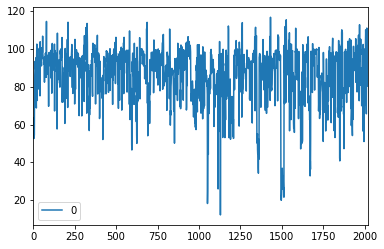

In [386]:
# Sum per fund
pd.DataFrame(holdings.sum(1)).plot()

95.86673557758331
Goldman Sachs Trust: Goldman Sachs Large Cap Value Fund; Service Shares


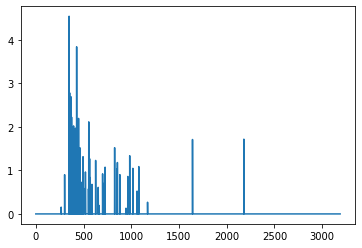

,security_name,cusip,crsp_company_key,col_old,col,sum
387,MICROSOFT CORP,59491810,3006728,591,564,1548.946399
455,GENERAL ELECTRIC CO,36960410,3004314,662,635,1321.133990
388,PFIZER INC,71708110,3008120,592,565,1225.247587
371,CISCO SYSTEMS INC,17275R10,3002250,574,547,1135.485505
415,INTEL CORP,45814010,3005322,621,594,960.901433


In [389]:
i = 70
print(np.sum(holdings[i,:].toarray().T))
print(row_info.fund_name[i])
plt.plot(holdings[i,:].toarray().T)
plt.show()
mask = (holdings[i,:].toarray().T > 0)
col_info.loc[mask.flatten()].sort_values(by='sum',ascending = False).head()

## Clustering

In [44]:
clustering = SpectralClustering(n_clusters=4,
                                assign_labels='discretize',
                                eigen_solver='amg',
                                n_jobs= -1,
                                random_state=0).fit(holdings)

/Users/alexandersteeb/.virtualenvs/MT/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [45]:
clustering.labels_

array([0, 0, 0, ..., 0, 3, 1])

In [568]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 4,
                verbose = True,
                n_init = 5, # Number of runs
                n_jobs= -1,
                random_state=123).fit(holdings)

Start kMeans...


In [47]:
labels = pd.DataFrame(clustering.labels_)

In [46]:
labels = pd.DataFrame(kmeans.labels_)

NameError: name 'kmeans' is not defined

In [48]:
summary['cluster'] = labels.values

In [49]:
summary.loc[summary.cluster == 2,['fund_name']].values

array([['American Beacon Funds: American Beacon Large Cap Value Fund; Institutional Class Shares'],
       ['BNY Mellon Funds Trust: BNY Mellon Large Cap Market Opportunities Fund; Investor Shares'],
       ['BNY Mellon Funds Trust: BNY Mellon Tax-Sensitve Large Cap Multi-Strategy Fund; Investor Shares'],
       ['JPMorgan Trust I: JPMorgan Intrepid Value Fund; Class A Shares'],
       ['Touchstone Strategic Trust: Touchstone Small Cap Growth Fund; Class Y Shares'],
       ['Frank Funds: Frank Value Fund; Investor Class Shares'],
       ['Nuveen Investment Trust: Nuveen NWQ Small/Mid-Cap Value Fund; Class I Shares'],
       ['Calvert Social Investment Fund: Calvert Equity Fund; Class A Shares'],
       ['Parnassus Funds: Parnassus Fund; Investor Class Shares'],
       ['Alger Portfolios: Alger SmallCap Growth Portfolio; Class I-2 Shares'],
       ['Federated Equity Income Fund, Inc; Class A Shares'],
       ['Wasatch Funds Trust: Wasatch Small Cap Growth Fund; Investor Class Shares'],


In [54]:
round(pd.crosstab(summary['cap_class'],summary['cluster'], margins = True, normalize = 'columns') * 100, 2)

cluster,0,1,2,3,All
cap_class,,,,,
E,6.79,7.94,7.14,7.94,7.37
L,39.54,25.56,21.43,24.51,31.36
M,30.01,39.45,47.62,42.15,36.44
S,23.66,27.05,23.81,25.40,24.84


In [55]:
round(pd.crosstab(summary['style_class'],summary['cluster'], margins = True, normalize = 'columns') * 100, 2)

cluster,0,1,2,3,All
style_class,,,,,
C,37.79,40.45,31.75,43.56,39.57
E,6.79,7.94,7.14,7.94,7.37
G,35.27,34.00,34.92,31.39,33.90
V,20.15,17.62,26.19,17.11,19.16


## Chart the returns of the formed clustes

In [558]:
summary.sample()

,level_0,index,port_no,report_dt,fund_name,avrcs,lipper_class,False,cap_class,style_class,fund_no,cluster
1639,1639,122578,1027281,2017-12-31,VALIC Company I: Large Capital Growth Fund,95.415532,LCGE,LCGE,L,G,30882,0


#### Merge new clusters into returns

In [559]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
18149,2017-12-29,6752.0,1026924.0,0.005298,SCGE,3.0


#### Calc mean return per Obj_cd

In [560]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([3., 0., 2., 1.])

In [561]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [562]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

In [567]:
plt.plot(clustering.cluster_centers_[0,:])

AttributeError: 'SpectralClustering' object has no attribute 'cluster_centers_'

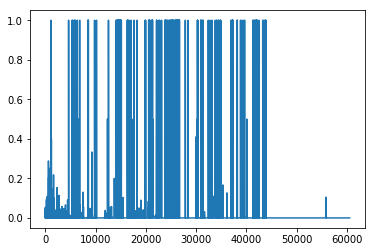

In [248]:
plt.plot(kmeans.cluster_centers_[1,:])

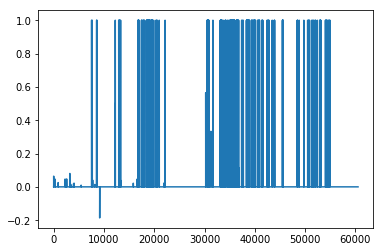

In [249]:
plt.plot(kmeans.cluster_centers_[2,:])

## PCA

In [ ]:
pca = PCA(n_components=10)
pca.fit(holdings.toarray())  

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

In [ ]:
df = pd.DataFrame(pca.components_).T
df = pd.DataFrame({
    'pca_1' : df.iloc[:,0],
    'pca_2' : df.iloc[:,1],
    'labels' : labels.iloc[:,0]
})

In [ ]:
df.plot.scatter(x='pca_1',
                y='pca_2',
                c='labels',
                colormap='viridis')

# Visualize

In [ ]:
MiniBatchKMeans?

For n_clusters = 2 The average silhouette_score is : 0.6655655253020518
For n_clusters = 3 The average silhouette_score is : -0.11048678935719358
For n_clusters = 4 The average silhouette_score is : -0.11397895334543343
For n_clusters = 5 The average silhouette_score is : -0.1770654711818058


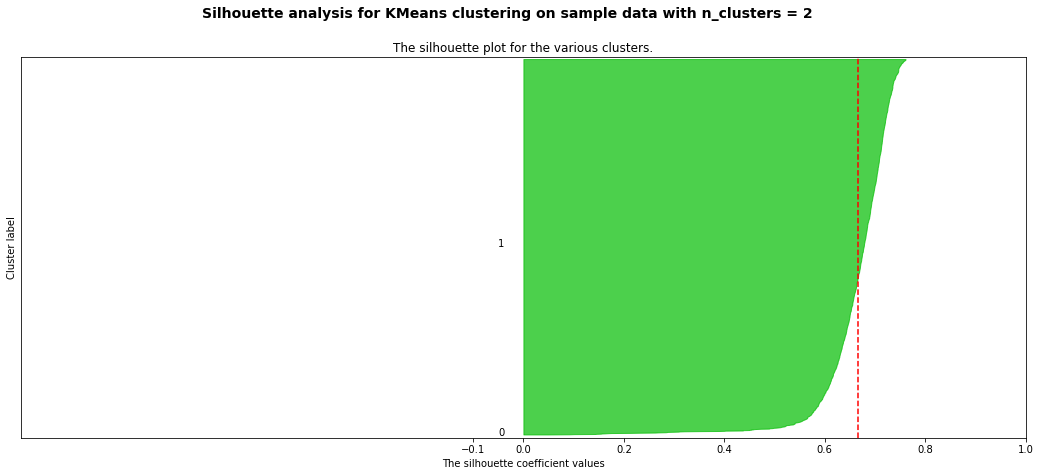

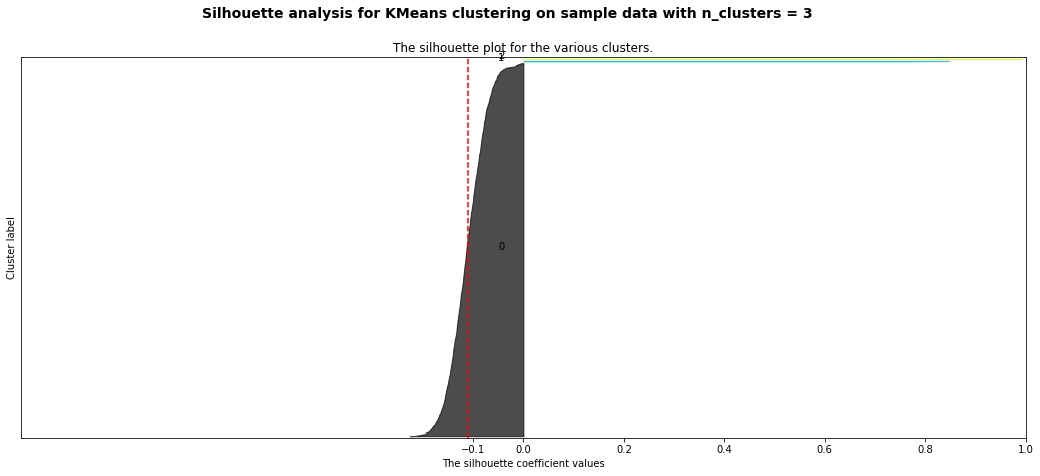

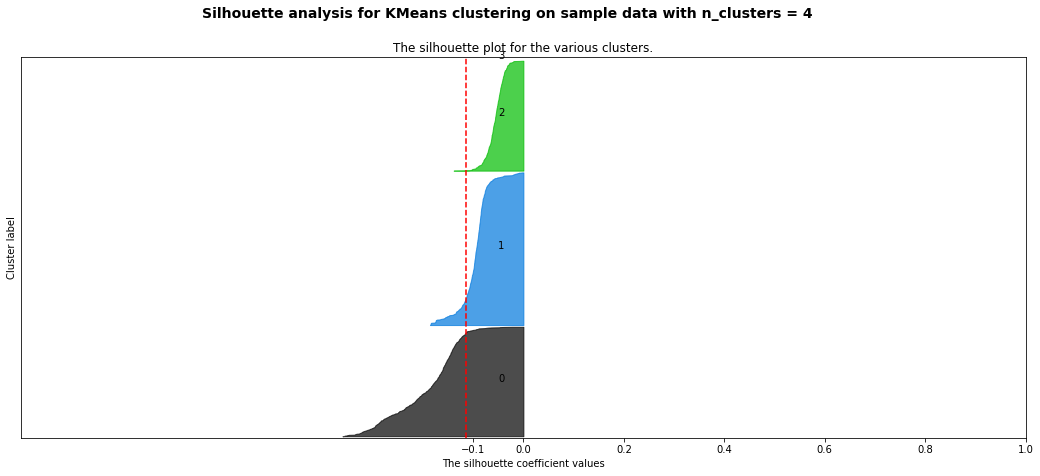

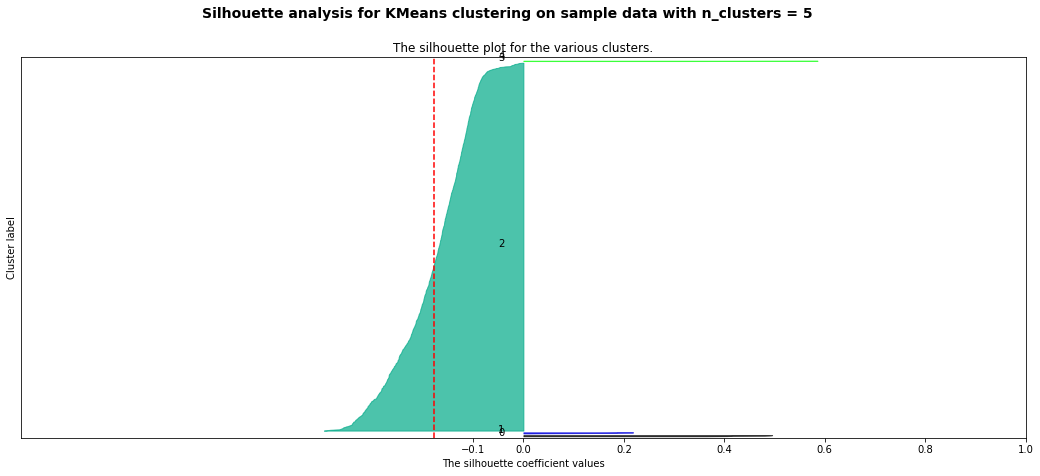

In [250]:
### Based on example code from sklearn ###

X = holdings
n_clusters = [2,3,4,5]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()